[1] "Hasil Hosmer–Lemeshow Test:"

   The Hosmer-Lemeshow goodness-of-fit test

 Group Size Observed  Expected
     1  120        2 0.8879212
     2  120        0 0.9221483
     3  120        0 0.9687906
     4  120        1 1.0340059
     5  120        1 1.1411522
     6  120        3 1.2799266
     7  122        2 1.5109636
     8  120        1 1.8301850
     9  120        2 2.5083891
    10  118        4 3.9165174

         Statistic =  6.31418 
degrees of freedom =  8 
           p-value =  0.61208 

$hm
   Group Size Observed  Expected
1      1  120        2 0.8879212
2      2  120        0 0.9221483
3      3  120        0 0.9687906
4      4  120        1 1.0340059
5      5  120        1 1.1411522
6      6  120        3 1.2799266
7      7  122        2 1.5109636
8      8  120        1 1.8301850
9      9  120        2 2.5083891
10    10  118        4 3.9165174

$statistic
[1] 6.314184

$df
[1] 8

$p.value
[1] "0.6120837"

[1] "Cutoff Score untuk Default Rate <= 5%:"
     score defa

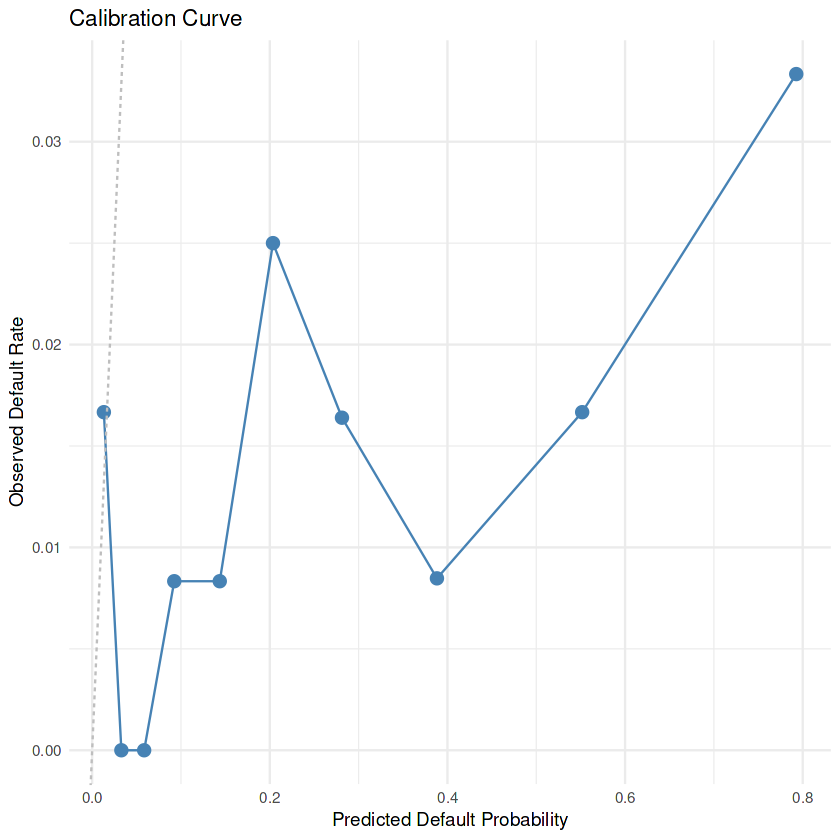

In [ ]:
# Install package
install.packages("ggplot2")
install.packages("glmtoolbox")

library(ggplot2)
library(glmtoolbox)

# === STEP 1: Load data ===
# File 'prob_test.csv' harus memiliki kolom: actual (0/1), prob (0–1)
df <- read.csv("/kaggle/input/datasetrr/prob_test.csv")

# === STEP 2: Hosmer–Lemeshow Test ===
model <- glm(actual ~ prob, data=df, family="binomial")
print("Hasil Hosmer–Lemeshow Test:")
print(hltest(model))

# === STEP 3: Calibration Plot ===
# Bin prediksi jadi 10 grup (decile)
df$bin <- cut(df$prob, breaks=quantile(df$prob, probs=seq(0, 1, 0.1)), include.lowest=TRUE)

# Hitung rata-rata aktual & prediksi per bin
cal <- aggregate(actual ~ bin, data=df, mean)
cal$pred <- aggregate(prob ~ bin, data=df, mean)$prob

# Plot kurva kalibrasi
ggplot(cal, aes(x=pred, y=actual)) +
  geom_point(size=3, color="steelblue") +
  geom_line(group=1, color="steelblue") +
  geom_abline(slope=1, intercept=0, linetype="dashed", color="gray") +
  labs(title="Calibration Curve",
       x="Predicted Default Probability",
       y="Observed Default Rate") +
  theme_minimal()

ggsave("calibration_curve.png", width=6, height=4)

# === STEP 4: Hitung Cutoff Skor untuk Expected Default Rate <= 5% ===
# Transformasi score menggunakan formula standar log-odds
A <- 600
B <- 50 / log(2)
df$score <- A + B * log((1 - df$prob) / df$prob)

# Urutkan score dan cari cutoff
thresholds <- sort(unique(df$score))
default_rates <- sapply(thresholds, function(th) {
  subset <- df[df$score >= th, ]
  if (nrow(subset) > 0) {
    mean(subset$actual)
  } else {
    NA
  }
})

cutoff_table <- data.frame(score=thresholds, default_rate=default_rates)
target_cutoff <- subset(cutoff_table, default_rate <= 0.05)[1, ]
print("Cutoff Score untuk Default Rate <= 5%:")
print(target_cutoff)
